In [1]:
# The first step is to load some standard python packages
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib
import datetime as dt
import matplotlib.dates as mdates

sns.set()

warnings.simplefilter("ignore")  # filter some warning messages

In [2]:
#Loading csv file as df
filename = "data/water quality data Dunea.csv"
df = pd.read_csv(
    filename, skipinitialspace=True, index_col=[1], parse_dates=True, dayfirst = True
)

#Translating all Dutch terms
df.index.name = "Time"
df = df.rename(columns={'Monstercode': 'Location', 'Eenheid': 'Unit', 'Waarde': 'Value', "Rapport waarde":"Reported value"})
df['Component'] = df['Component'].replace(['Zuurgraad'], 'Acidity')
df['Component'] = df['Component'].replace(['Temperatuur'], 'Temperature')

# Splitting up data into different components
# Components cannot be placed as columns since the times of measurement and locations differ
df_iopromide = df[df["Component"] == "iopromide"]
df_MTBE = df[df["Component"] == "methyl-tertiair-butylether (MTBE)"] 
df_Chloride = df[df["Component"] == "Chloride"]
df_fluopyram = df[df["Component"] == "fluopyram"]
df_Temp = df[df["Component"] == "Temperature"]
df_diclofenac = df[df["Component"] == "diclofenac"]
df_sucralose = df[df["Component"] == "sucralose"]
df_ph = df[df["Component"] == "Acidity"]
datasets = [df_iopromide, df_MTBE, df_Chloride, df_fluopyram, df_Temp, df_diclofenac, df_sucralose, df_ph]

knmi_data = pd.read_csv('data/knmi_data_weather.txt', skiprows=9, index_col=1, parse_dates=True, skipinitialspace=True)
rws_discharge_data = pd.read_csv('data/rws_data_discharge.csv', delimiter=';', parse_dates=[['WAARNEMINGDATUM', 'WAARNEMINGTIJD (MET/CET)']], index_col=0)
rws_water_temp_data = pd.read_csv('data/rws_data_watertemp.csv', delimiter=';', parse_dates=[['WAARNEMINGDATUM', 'WAARNEMINGTIJD (MET/CET)']], index_col=0)

discharge = pd.DataFrame(rws_discharge_data['ALFANUMERIEKEWAARDE'])
discharge.index = pd.to_datetime(discharge.index, format='%d/%m/%Y %H:%M:%S')
temperature = pd.DataFrame(rws_water_temp_data['ALFANUMERIEKEWAARDE'])
temperature.index = pd.to_datetime(temperature.index, format='%d/%m/%Y %H:%M:%S')
precipitation = pd.DataFrame(knmi_data.loc['2010':]['RH'] / 10)
discharge = discharge.rename(columns={'ALFANUMERIEKEWAARDE': 'Discharge (m3/s)'})
temperature = temperature.rename(columns={'ALFANUMERIEKEWAARDE': 'Temperature (C)'})

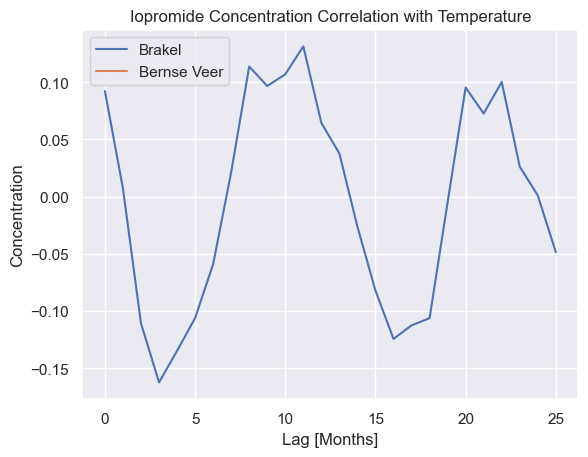

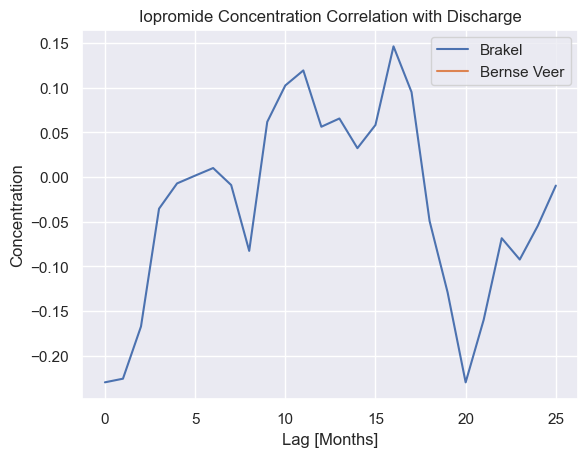

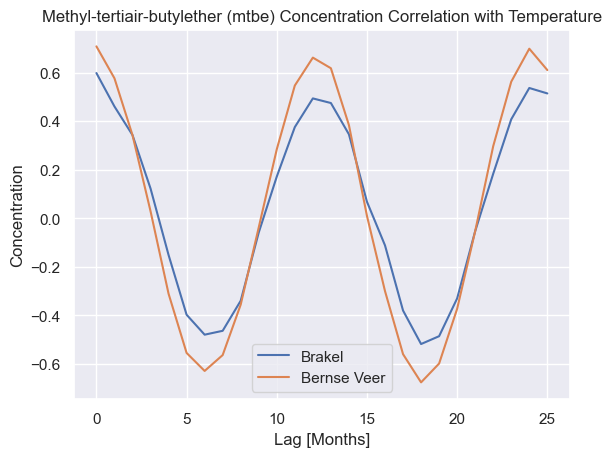

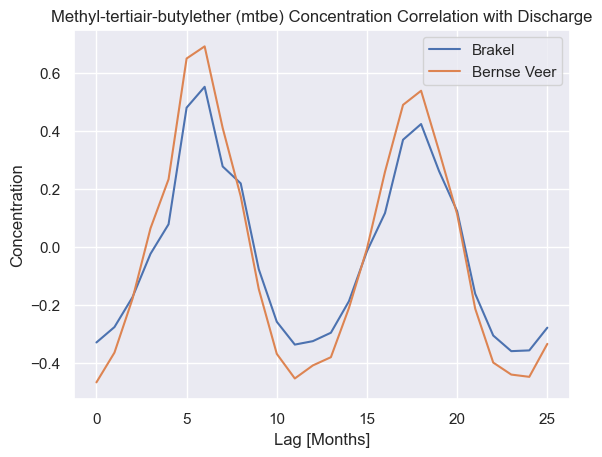

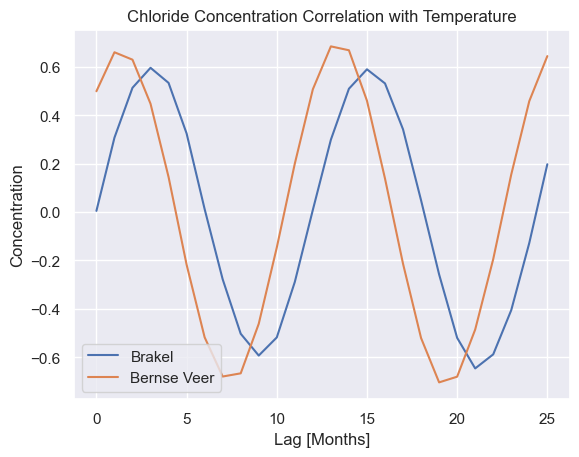

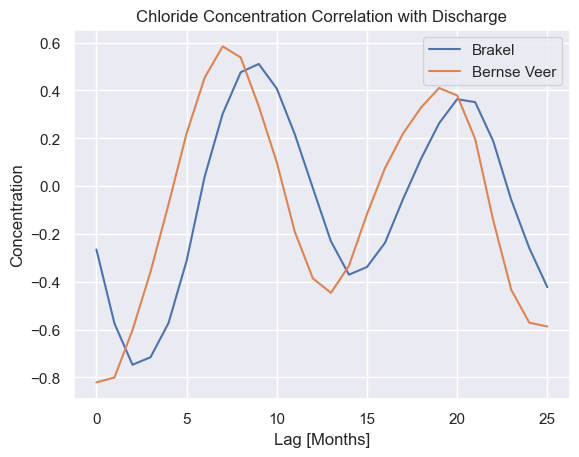

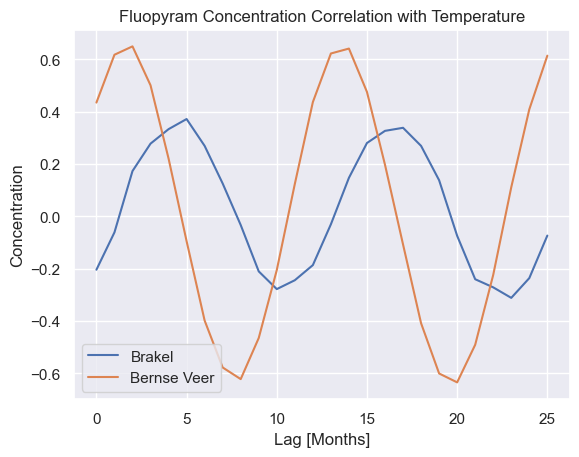

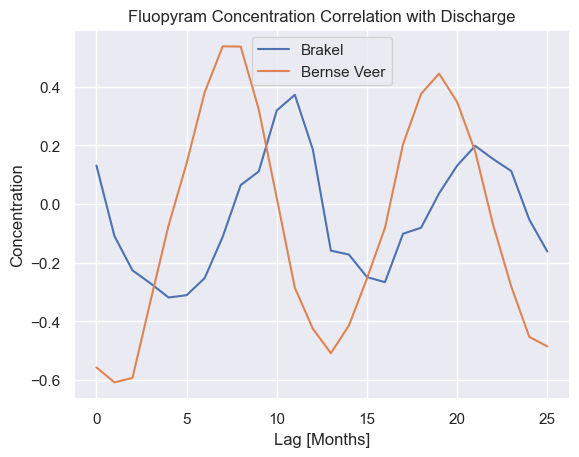

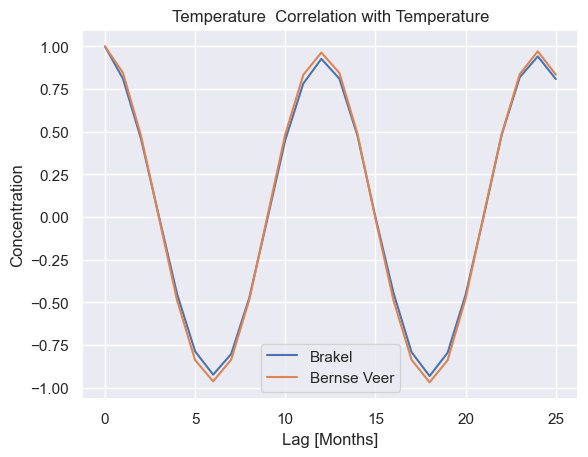

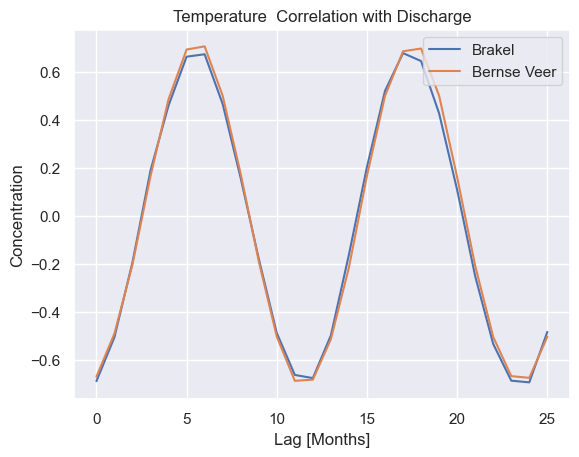

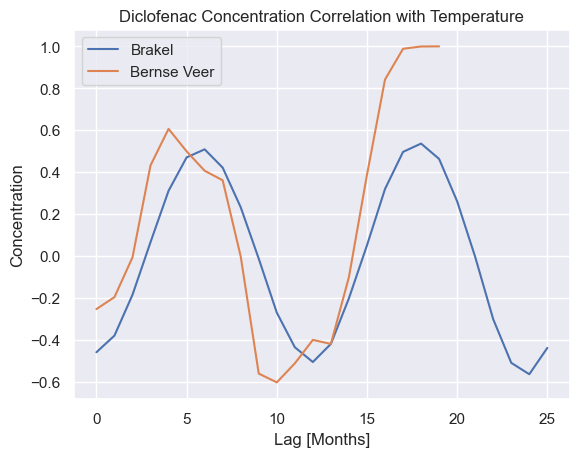

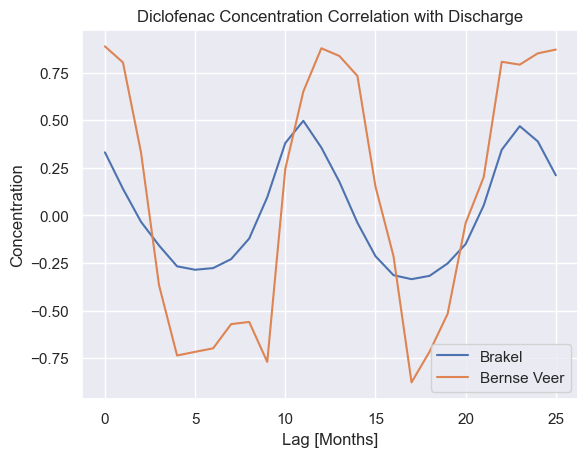

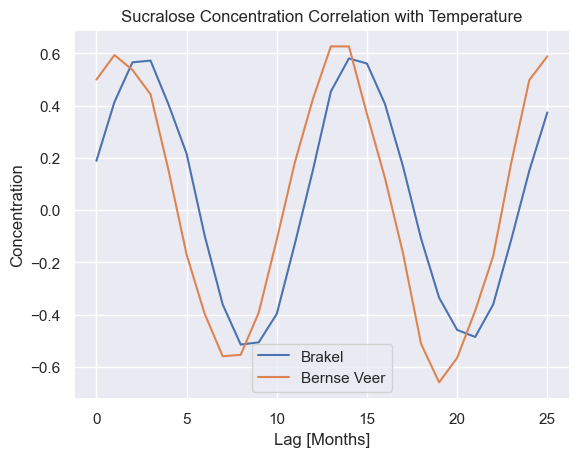

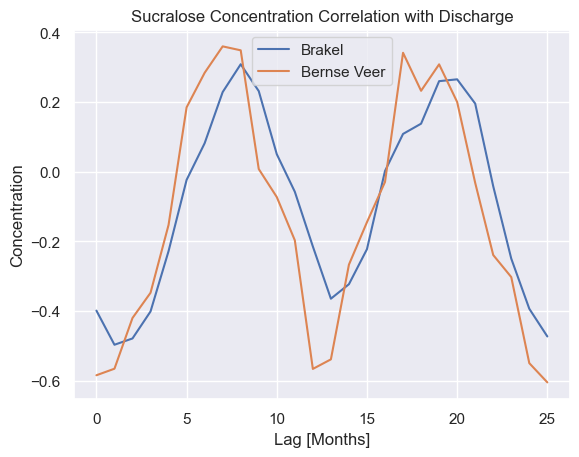

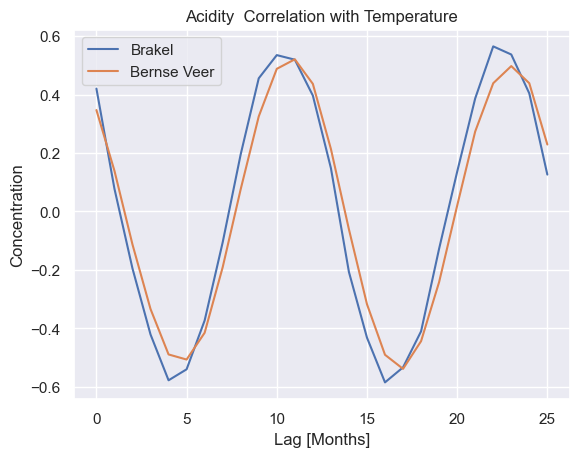

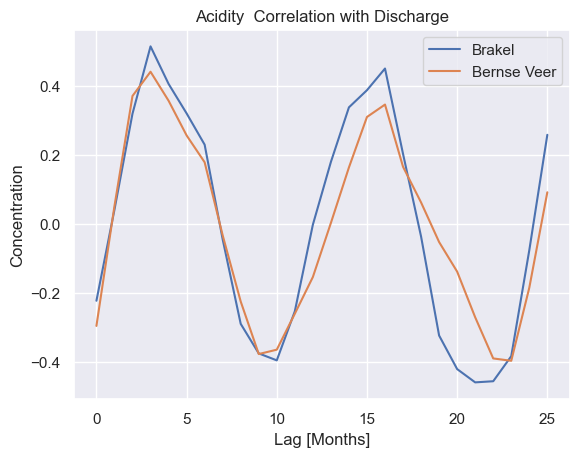

In [11]:
def correlation_lag(lag, df1, df2):
    df2 = df2.rename("Value2")
    df2_lagged = df2.shift(lag)
    df = pd.concat([df1, df2_lagged], axis=1, join = 'inner').reset_index()
    correlation = df.corr()
    # return(correlation["RH"]["discharge (m3/s)"])
    return(correlation["Value"]["Value2"])
    

def correlation_analysis(df, freq):
    #Some general formatting
    #Strings can be given as an input to alter the filename or title
    Component = df["Component"][1].capitalize()
    if Component != "Temperature" and Component != "Acidity":
        conc_string = "Concentration"
    else:
        conc_string = ""
    label_y = Component + conc_string +"  [" + df["Unit"][1] +"]"
    
    df_br = df[df["Location"] == "Brakel"]["Value"]
    df_bv = df[df["Location"] == "Bernse Veer"]["Value"]
    df_temp_br = df_Temp[df_Temp["Location"] == "Brakel"]["Value"]
    df_temp_bv = df_Temp[df_Temp["Location"] == "Bernse Veer"]["Value"]
    
    freq = "M"
    df_br_mean = df_br.resample(freq).mean()
    df_bv_mean = df_bv.resample(freq).mean()
    df_temp_br_mean = df_temp_br.resample(freq).mean()
    df_temp_bv_mean = df_temp_bv.resample(freq).mean()
    df_discharge_mean = discharge.resample(freq).mean()
    df_discharge_mean = df_discharge_mean.squeeze()
    
    lags_number = 24
    lags = np.arange(0,lags_number)
    correlations_br_temp = []
    correlations_bv_temp = []
    correlations_br_dis = []
    correlations_bv_dis = []
    for i in lags:
        correlations_br_temp.append(correlation_lag(i, df_br_mean, df_temp_br_mean))
        correlations_bv_temp.append(correlation_lag(i, df_bv_mean, df_temp_bv_mean))

        correlations_br_dis.append(correlation_lag(i, df_br_mean, df_discharge_mean))
        correlations_bv_dis.append(correlation_lag(i, df_bv_mean, df_discharge_mean))

    plt.plot(lags, correlations_br_temp, label = "Brakel")
    plt.plot(lags, correlations_bv_temp, label = "Bernse Veer")
    plt.title(Component + " " + conc_string + " " + "Correlation with Temperature")
    plt.xlabel("Lag [Months]")
    plt.ylabel("Concentration") 
    plt.legend()
    plt.show()
               
    plt.plot(lags, correlations_br_dis, label = "Brakel")
    plt.plot(lags, correlations_bv_dis, label = "Bernse Veer")           
    plt.title(Component + " " + conc_string + " " + "Correlation with Discharge")
    plt.xlabel("Lag [Months]")
    plt.ylabel("Concentration") #Change this 
    plt.legend()
    plt.show()
    
# correlation_analysis(df_fluopyram)
for df in datasets:
    correlation_analysis(df,freq)